# Analisis de Sentimiento

Lucho Feb | 2022 <br>
Raphael by Carla Bruni

Este conjunto de datos consiste en unos pocos millones de reseñas de clientes de Amazon (texto de entrada) y calificaciones por estrellas (etiquetas de salida) para aprender a entrenar **fastText** en tareas de análisis de sentimientos.

La idea es que este conjunto de datos sea más que un simple ejemplo: se trata de datos reales de negocio a una escala razonable, pero que pueden ser entrenados en minutos en una laptop modesta.

Dataset: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

## Import Packages

In [1]:
# Librerías estándar
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error,mean_squared_log_error, accuracy_score,confusion_matrix, 
                             classification_report)
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall, AUC
import tensorflow as tf

from keras.models import Sequential 
from keras.layers import (BatchNormalization, Conv2D, Dense, Dropout, Flatten,MaxPool2D, MaxPooling2D,Embedding,LSTM,SimpleRNN)
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping 
import tensorflow as tf

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

## Import Dataset

In [2]:
df = pd.read_csv(r"IMDB Dataset.csv")
df_raw = df.copy()
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.shape

(50000, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
df = df.sample(n=5000, random_state=42).reset_index(drop=True)
df.head()

,review,sentiment
0,I really liked this Summerslam due to the look...,positive
1,Not many television shows appeal to quite as m...,positive
2,The film quickly gets to a major chase scene w...,negative
3,Jane Austen would definitely approve of this o...,positive
4,Expectations were somewhat high for me when I ...,negative


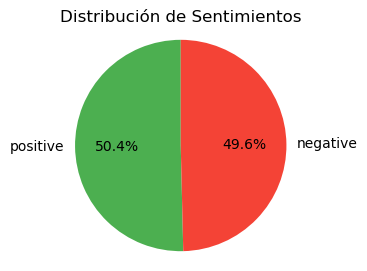

In [7]:
# Contar ocurrencias de cada sentimiento
sentiment_counts = df['sentiment'].value_counts()
# Crear el gráfico de pastel
plt.figure(figsize=(3, 3))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#4CAF50', '#F44336']  # verde para positivo, rojo para negativo
)
plt.title('Distribución de Sentimientos')
plt.axis('equal')  # Para que el pastel sea circular
plt.show()

In [8]:
# Descargar las stopwords en español si no están descargadas
nltk.download('stopwords')

# Función de preprocesamiento de texto
def preprocesar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()

    # Eliminar etiquetas HTML
    texto = re.sub(r'<.*?>', '', texto)

    # Eliminar signos de puntuación y números
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = re.sub(r'\d+', '', texto)

    # Eliminar stopwords (palabras vacías) en español
    palabras_vacias = set(stopwords.words('spanish'))
    texto = ' '.join([palabra for palabra in texto.split() if palabra not in palabras_vacias])

    # Eliminar espacios extra
    texto = ' '.join(texto.split())

    return texto

# Aplicar el preprocesamiento a la columna 'review'
df['texto_limpio'] = df['review'].apply(preprocesar_texto)

# Mostrar el DataFrame
df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Luciano\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review,sentiment,texto_limpio
0,I really liked this Summerslam due to the look...,positive,i really liked this summerslam due to the look...
1,Not many television shows appeal to quite as m...,positive,not many television shows appeal to quite as m...
2,The film quickly gets to a major chase scene w...,negative,the film quickly gets to major chase scene wit...
3,Jane Austen would definitely approve of this o...,positive,jane austen would definitely approve of this o...
4,Expectations were somewhat high for me when I ...,negative,expectations were somewhat high for when i wen...
...,...,...,...
4995,One of eastwood's best movies after he had sep...,positive,one of eastwoods best movies after had separat...
4996,My blurred childhood memories have kept the ec...,negative,my blurred childhood memories have kept the ec...
4997,I love Zombie-Movies and I love amateur-produc...,negative,i love zombiemovies and i love amateurproducti...
4998,Chan is in New York and he gets involved with ...,positive,chan is in new york and gets involved with an ...


In [9]:
# Codificar las etiquetas de sentimiento (por ejemplo, positive -> 1, negative -> 0)
label_encoder = LabelEncoder()
df['encoded_sentiment'] = label_encoder.fit_transform(df['sentiment'])

In [10]:
# Configurar el tokenizador
tokenizer = Tokenizer(num_words=10000, oov_token="")
tokenizer.fit_on_texts(df['texto_limpio'])

# Convertir el texto a secuencias de enteros
sequences = tokenizer.texts_to_sequences(df['texto_limpio'])

# Mostrar el DataFrame actualizado
df.head()

,review,sentiment,texto_limpio,encoded_sentiment
0,I really liked this Summerslam due to the look...,positive,i really liked this summerslam due to the look...,1
1,Not many television shows appeal to quite as m...,positive,not many television shows appeal to quite as m...,1
2,The film quickly gets to a major chase scene w...,negative,the film quickly gets to major chase scene wit...,0
3,Jane Austen would definitely approve of this o...,positive,jane austen would definitely approve of this o...,1
4,Expectations were somewhat high for me when I ...,negative,expectations were somewhat high for when i wen...,0


In [11]:
print(f"Tokenizer word index:\n{tokenizer.word_index}")

Tokenizer word index:
{'': 1, 'the': 2, 'and': 3, 'of': 4, 'to': 5, 'is': 6, 'in': 7, 'it': 8, 'this': 9, 'i': 10, 'that': 11, 'was': 12, 'as': 13, 'for': 14, 'with': 15, 'movie': 16, 'but': 17, 'film': 18, 'on': 19, 'you': 20, 'not': 21, 'his': 22, 'are': 23, 'have': 24, 'be': 25, 'one': 26, 'its': 27, 'at': 28, 'all': 29, 'by': 30, 'they': 31, 'an': 32, 'who': 33, 'from': 34, 'like': 35, 'so': 36, 'or': 37, 'just': 38, 'about': 39, 'her': 40, 'if': 41, 'out': 42, 'some': 43, 'good': 44, 'there': 45, 'what': 46, 'more': 47, 'when': 48, 'very': 49, 'up': 50, 'even': 51, 'which': 52, 'would': 53, 'time': 54, 'my': 55, 'only': 56, 'she': 57, 'really': 58, 'see': 59, 'were': 60, 'their': 61, 'can': 62, 'had': 63, 'story': 64, 'get': 65, 'much': 66, 'than': 67, 'well': 68, 'other': 69, 'been': 70, 'will': 71, 'into': 72, 'we': 73, 'because': 74, 'people': 75, 'great': 76, 'how': 77, 'most': 78, 'first': 79, 'bad': 80, 'also': 81, 'do': 82, 'films': 83, 'dont': 84, 'him': 85, 'them': 86, 'm

In [12]:
sequences[0:3]

[[10,
  58,
  432,
  9,
  1,
  614,
  5,
  2,
  158,
  4,
  2,
  9447,
  2,
  1,
  3,
  38,
  2,
  158,
  505,
  12,
  207,
  5,
  14,
  43,
  269,
  4772,
  9,
  94,
  24,
  70,
  26,
  4,
  2,
  105,
  1,
  117,
  41,
  2,
  1,
  140,
  24,
  7742,
  1,
  7,
  2,
  299,
  1335,
  411,
  7127,
  145,
  14,
  27,
  54,
  8,
  12,
  735,
  5,
  24,
  572,
  1461,
  123,
  1674,
  553,
  123,
  17,
  138,
  1108,
  210,
  24,
  1125,
  8,
  12,
  392,
  299,
  1335,
  38,
  35,
  161,
  1068,
  1,
  6,
  7,
  6,
  392,
  69,
  4577,
  19,
  2,
  3504,
  60,
  6237,
  6238,
  1674,
  4064,
  1,
  9448,
  1004,
  1674,
  1,
  1725,
  7743,
  4395,
  1674,
  1,
  1,
  9,
  12,
  2,
  1335,
  112,
  7743,
  737,
  22,
  190,
  634,
  4,
  635,
  3096,
  7128,
  1,
  1674,
  599,
  1,
  4578,
  79,
  295,
  19,
  1,
  88,
  295,
  19,
  1866,
  1,
  3,
  448,
  15,
  2,
  1,
  3,
  1,
  12,
  203,
  49,
  207,
  88,
  1,
  1,
  2153,
  4773,
  1,
  8493,
  516,
  19,
  1572,
  1,
  7,
  144,


In [13]:
max_len = max([len(seq) for seq in sequences])
max_len    

953

In [14]:
# Rellenar (completar) las secuencias
max_len = 582  # Longitud máxima de las secuencias
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

### Entrenar un modelo RNN simple

In [15]:
# Construir el modelo
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=max_len),  # Capa de embedding para representar palabras como vectores
    SimpleRNN(128, activation='tanh', return_sequences=True),  # Capa RNN con más unidades y devuelve secuencias
    Dropout(0.5),  # Dropout para prevenir el sobreajuste (overfitting)
    SimpleRNN(64, activation='tanh'),  # Otra capa RNN adicional
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Capa de salida con activación sigmoide para clasificación binaria
])
# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizador Adam con tasa de aprendizaje de 0.001
    loss='binary_crossentropy',           # Función de pérdida para clasificación binaria
    metrics=[ #Metricas
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]                 
)

model.summary()

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the model
history = model.fit(padded_sequences, df['encoded_sentiment'], epochs=10, batch_size=64, validation_split=0.2)     


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 366ms/step - accuracy: 0.4927 - auc: 0.4946 - loss: 0.7946 - precision: 0.4997 - recall: 0.4906 - val_accuracy: 0.5360 - val_auc: 0.5431 - val_loss: 0.6915 - val_precision: 0.5351 - val_recall: 0.4196
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - accuracy: 0.4918 - auc: 0.4863 - loss: 0.8053 - precision: 0.4987 - recall: 0.4906 - val_accuracy: 0.5000 - val_auc: 0.5083 - val_loss: 0.6964 - val_precision: 0.4897 - val_recall: 0.4358
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 295ms/step - accuracy: 0.4978 - auc: 0.4966 - loss: 0.7854 - precision: 0.5046 - recall: 0.5123 - val_accuracy: 0.4950 - val_auc: 0.4998 - val_loss: 0.6968 - val_precision: 0.4844 - val_recall: 0.4420
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 284ms/step - accuracy: 0.4927 - auc: 0.4953 - loss: 0.7706 - precision: 0.4998 - recall: 0.4985 - val_accuracy: 0.4870 - val_auc: 0.4842 - val_loss: 0.7001 - val_precision: 0.4813 - val_recall: 0.5764
Epoch 5/10
63/63 ━━━━━━━━━━━

### Graficos de Metricas

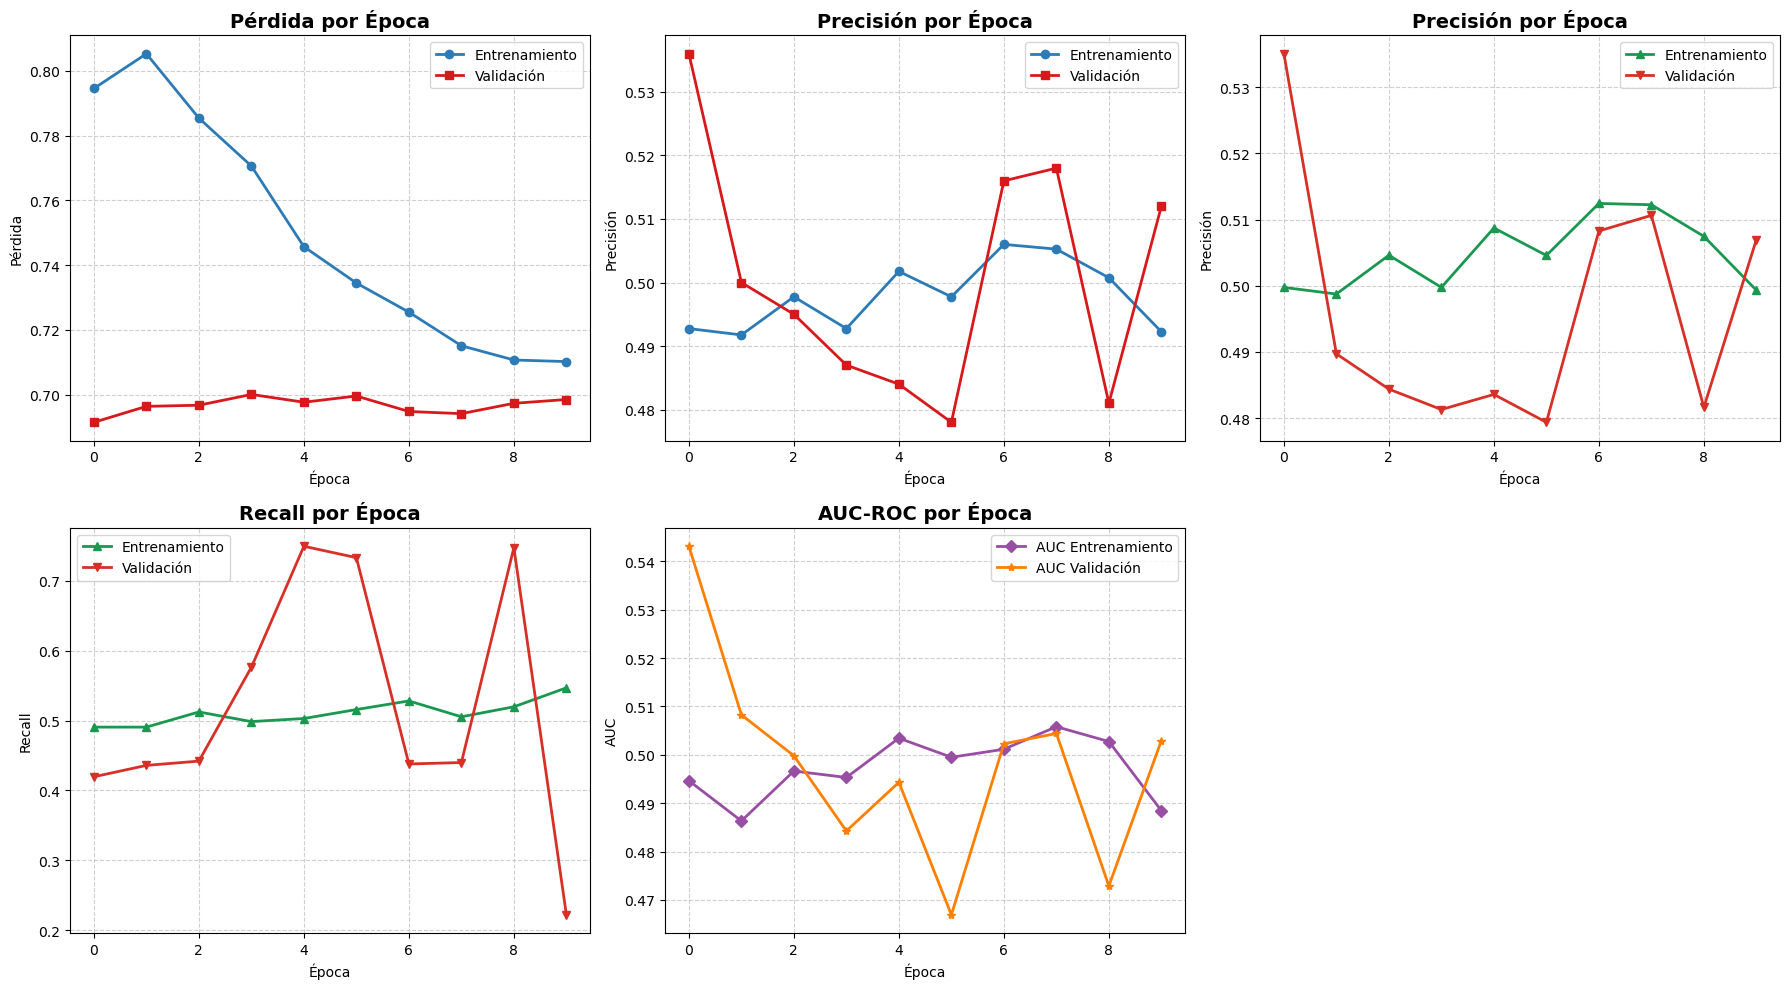

In [17]:
# Crear la figura y los subgráficos
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Graficar Pérdida por Época
axes[0, 0].plot(history.history['loss'], label='Entrenamiento', color='#2C7BB6', marker='o', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validación', color='#D7191C', marker='s', linewidth=2)
axes[0, 0].set_title('Pérdida por Época', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Pérdida')
axes[0, 0].grid(True, linestyle='--', alpha=0.6)
axes[0, 0].legend()

# Graficar Precisión por Época
axes[0, 1].plot(history.history['accuracy'], label='Entrenamiento', color='#2C7BB6', marker='o', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validación', color='#D7191C', marker='s', linewidth=2)
axes[0, 1].set_title('Precisión por Época', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Precisión')
axes[0, 1].grid(True, linestyle='--', alpha=0.6)
axes[0, 1].legend()

# Graficar Precisión (Positive Predictive Value) por Época
axes[0, 2].plot(history.history['precision'], label='Entrenamiento', color='#1A9850', marker='^', linewidth=2)
axes[0, 2].plot(history.history['val_precision'], label='Validación', color='#D73027', marker='v', linewidth=2)
axes[0, 2].set_title('Precisión por Época', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Época')
axes[0, 2].set_ylabel('Precisión')
axes[0, 2].grid(True, linestyle='--', alpha=0.6)
axes[0, 2].legend()

# Graficar Recall por Época
axes[1, 0].plot(history.history['recall'], label='Entrenamiento', color='#1A9850', marker='^', linewidth=2)
axes[1, 0].plot(history.history['val_recall'], label='Validación', color='#D73027', marker='v', linewidth=2)
axes[1, 0].set_title('Recall por Época', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].grid(True, linestyle='--', alpha=0.6)
axes[1, 0].legend()

# Graficar AUC por Época
axes[1, 1].plot(history.history['auc'], label='AUC Entrenamiento', color='#984EA3', marker='D', linewidth=2)
axes[1, 1].plot(history.history['val_auc'], label='AUC Validación', color='#FF7F00', marker='*', linewidth=2)
axes[1, 1].set_title('AUC-ROC por Época', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Época')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].grid(True, linestyle='--', alpha=0.6)
axes[1, 1].legend()

# Dejar el último subgráfico vacío
axes[1, 2].axis('off')

# Ajustar el layout para evitar superposiciones
plt.tight_layout()
plt.show()

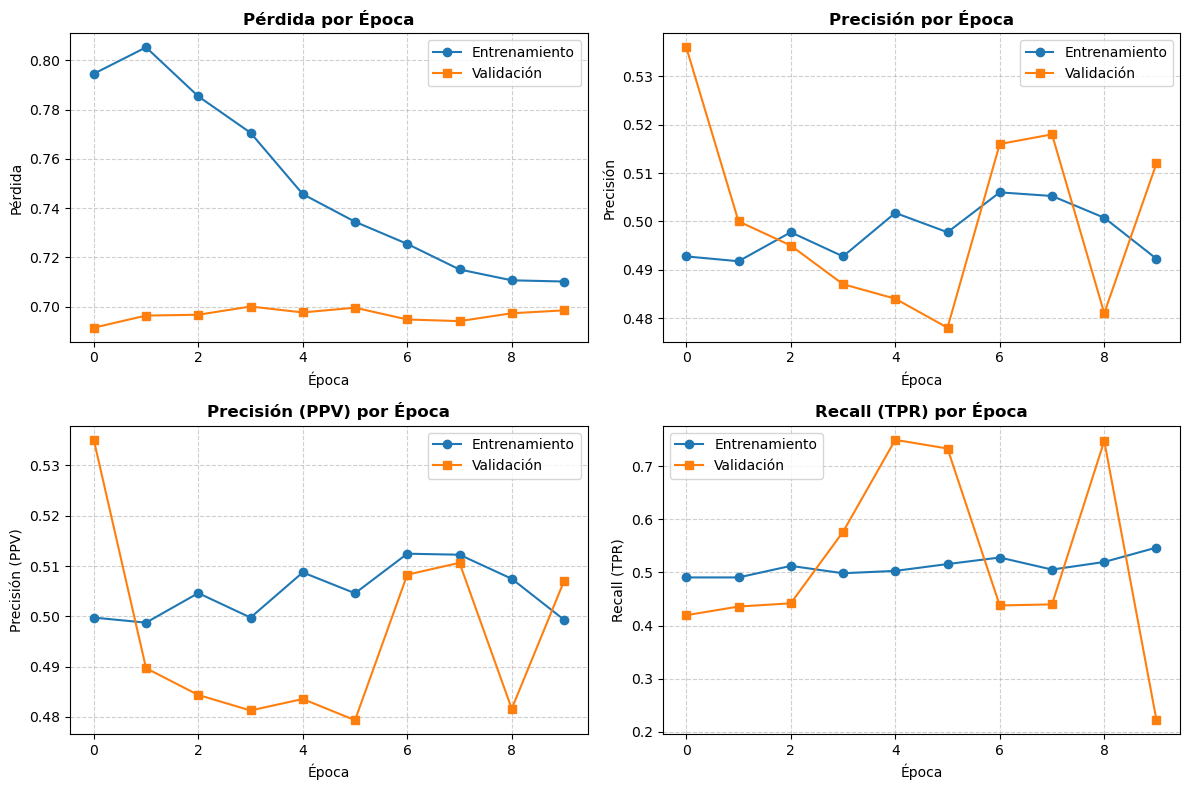

In [18]:
metrics_to_plot = {
    'loss': 'Pérdida',
    'accuracy': 'Precisión',
    'precision': 'Precisión (PPV)',
    'recall': 'Recall (TPR)'
}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, (metric, title) in enumerate(metrics_to_plot.items()):
    axes[i].plot(history.history[metric], label='Entrenamiento', marker='o')
    axes[i].plot(history.history[f'val_{metric}'], label='Validación', marker='s')
    axes[i].set_title(f'{title} por Época', fontweight='bold')
    axes[i].set_xlabel('Época')
    axes[i].set_ylabel(title)
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step


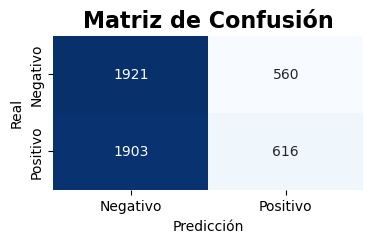

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.77      0.61      2481
           1       0.52      0.24      0.33      2519

    accuracy                           0.51      5000
   macro avg       0.51      0.51      0.47      5000
weighted avg       0.51      0.51      0.47      5000



In [19]:
# Predicción de sentimiento
y_pred = (model.predict(padded_sequences) > 0.5).astype("int32")

# Matriz de confusión
cm = confusion_matrix(df['encoded_sentiment'], y_pred)

# Mostrar la matriz de confusión
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión', fontsize=16, fontweight='bold')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Reporte de clasificación
print("Classification Report:\n", classification_report(df['encoded_sentiment'], y_pred))

##### Guardar Modelo

In [20]:
# Guardar el modelo
model.save('sentiment_rnn_model.h5')

# Cargar el modelo
from tensorflow.keras.models import load_model
loaded_model = load_model('sentiment_rnn_model.h5')

#### Testeo

In [21]:
def predict_sentiment(sentence):
    # Preprocesar la oración de entrada
    sentence = preprocesar_texto(sentence)

    # Tokenizar y rellenar (padding) la oración
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

    # Predecir el sentimiento
    prediction = loaded_model.predict(padded_sequence)
    if prediction > 0.5:
        return "Negativo"
    else:
        return "Positivo"


In [22]:
test_sentence = "I love this product!"
print(f"Sentimiento: {predict_sentiment(test_sentence)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Sentimiento: Positivo


In [23]:
test_sentence = "I hate this movie!"
print(f"Sentiment: {predict_sentiment(test_sentence)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Sentiment: Positivo
